# Predict Credit Default

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
df = pd.read_csv('../data/hmeq.csv')

In [3]:
df.head(5)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


C:\Users\srema\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\srema\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 456.,  415.,  696., 1003., 1093.,  629.,  596.,  394.,  148.,
          15.]),
 array([0.        , 0.64031242, 1.28062485, 1.92093727, 2.56124969,
        3.20156212, 3.84187454, 4.48218697, 5.12249939, 5.76281181,
        6.40312424]),
 <a list of 10 Patch objects>)

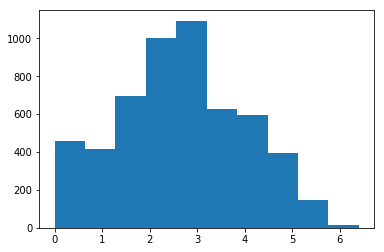

In [4]:
plt.hist(np.sqrt(df['YOJ']))

In [5]:
df.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


In [6]:
df.isna().sum()

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

In [7]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

class DataCleaner:
    
    def __init__(self, df, predict_nan=True):
        
        self.df = df.copy()
        self.predict_nan = predict_nan
        
        
    def fill_na_model(self, df_train, target):

        X = df_train.drop(['BAD', 'DEROG', 'DELINQ'], axis=1)
        y = df_train[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

        clf = GradientBoostingRegressor(random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        r2 = r2_score(y_test, y_pred)

        return clf


    def predict_na(self, target, clf=None):

        df_train = self.df[~self.df[target].isna()]
        df_test = self.df[self.df[target].isna()]
        df_test_ = df_test.drop(columns=['BAD', 'DEROG', 'DELINQ'], axis=1)

        if clf == None:
            clf = self.fill_na_model(df_train, target)

        y_pred = clf.predict(df_test_)
        df_test[target] = y_pred
        df_new = pd.concat([df_train, df_test])

        return df_new, clf
    
    
    def dummy_replace(self, column, prefix=None):

        df_dummy = pd.get_dummies(self.df[column], prefix=prefix)
        self.df = pd.concat([self.df, df_dummy], axis=1)
        self.df = self.df.drop(columns=[column], axis=1)
   

    def fill_nan(self): 

        self.df['MORTDUE'] = self.df['MORTDUE'].fillna(self.df['MORTDUE'].median())
        self.df['VALUE'] = self.df['VALUE'].fillna(self.df['VALUE'].median())
        self.df['REASON'] = self.df['REASON'].fillna('Unknown')
        self.df['JOB'] = self.df['JOB'].fillna('Unknown')
        self.df['YOJ'] = self.df['YOJ'].fillna(self.df['YOJ'].median())
        self.df['CLAGE'] = self.df['CLAGE'].fillna(self.df['CLAGE'].median())
        self.df['NINQ'] = self.df['NINQ'].fillna(self.df['NINQ'].median()) 
        self.df['CLNO'] = self.df['CLNO'].fillna(self.df['CLNO'].median()) 
        self.df['DEBTINC'] = self.df['DEBTINC'].fillna(self.df['DEBTINC'].median()) 
        
        if self.predict_nan == False:

            self.df['DEROG'] = self.df['DEROG'].fillna(self.df['DEROG'].mean()) 
            self.df['DELINQ'] = self.df['DELINQ'].fillna(self.df['DELINQ'].mean()) 
        

    def feature_engineering(self):

        self.df['LOAN'] = np.log(self.df['LOAN'])
        self.df['MORTDUE'] = np.log(self.df['MORTDUE'])
        self.df['VALUE'] = np.log(self.df['VALUE'])
        self.df['YOJ'] = np.sqrt(self.df['YOJ'])


    def clean(self, clf_derog=None, clf_delinq=None):
        
        self.fill_nan()
        self.feature_engineering()

        self.dummy_replace('REASON', prefix='Reason')
        self.dummy_replace('JOB', prefix='Job')
        
        if self.predict_nan:
            self.df, self.clf_derog = self.predict_na('DEROG', clf=clf_derog)
            self.df, self.clf_delinq = self.predict_na('DELINQ', clf=clf_delinq)

        return self.df


In [8]:
# df_clean = DataCleaner(df).clean()
# df_clean

In [9]:
# df_ = data_cleaning(df)

In [10]:
# df_.head(5)

In [11]:
import random

class EnsembleModel():
    
    def __init__(self, solver='lbfgs', random_state=42, test_size=0.33, sample_frac=0.8, rounds=100,
                row_sampling=True, max_iter=100, predict_nan=True):
        
        self.solver = solver
        self.random_state = random_state
        self.test_size = test_size
        self.sample_frac = sample_frac
        self.rounds = rounds
        self.max_iter = max_iter
        self.row_sampling = row_sampling
        self.predict_nan = predict_nan
        
        random.seed(self.random_state)
    
    
    def sample_rows(self, X, y, random_state):
        
        no_sample_rows = int(self.rows * self.sample_frac)
        row_indices = list(range(self.rows))
        
        X_rows = random.choices(row_indices, k=no_sample_rows)
        X_sample = np.zeros((no_sample_rows,X.shape[1]))
        y_sample = np.zeros((no_sample_rows,))
        
        for i, row in enumerate(X_rows):
            X_sample[i,:] = X[row,:]
            y_sample[i] = y[row]
            
        return X_sample, y_sample
        
    
    def sample_columns(self, X, y, random_state):
        
        random.seed(random_state)
        
        no_sample_cols = int(self.cols * self.sample_frac)
        column_indices = list(range(self.cols))
        
        X_cols = random.sample(column_indices, no_sample_cols)
        X_sample = X[:, X_cols]
        
        if self.row_sampling == True:
            X_sample, y_sample = self.sample_rows(X_sample, y, random_state)
        else:
            y_sample = y

        return X_sample, y_sample, X_cols
    
        
    
    def fit(self, X, y):
        
        self.rows = X.shape[0]
        self.cols = X.shape[1]
        
        X = X.values
        y = y.values
        
        self.__clf_dict = {}
        
        for i in range(self.rounds):
            X_sample, y_sample, X_cols = self.sample_columns(X, y,random_state=i)
            
            clf = LogisticRegression(solver=self.solver, random_state=self.random_state, 
                                     max_iter=self.max_iter)
            clf.fit(X_sample, y_sample)
            self.__clf_dict[i] = [clf, X_cols]
        
        return None
    
    
    def predict(self, X):
        
        X = X.values        
        y_pred_mat = np.zeros((len(X), self.rounds))
        
        for key, value in self.__clf_dict.items():
            model = value[0]
            cols = value[1]
            y_pred_mat[:,key] = model.predict(X[:,cols])
            
        y_pred = np.mean(y_pred_mat, axis=1)
        
        return y_pred, y_pred_mat

In [12]:
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

class ModelPipeline():
    
    def __init__(self, df, test_size=0.33, random_state=42, row_sampling=True,
                rounds=250, max_iter=100, simple_model=False, mean_model=False,
                cutoff=0, model_name=None, solver='lbfgs', predict_nan=True):
        
        self.df = df
        self.test_size = test_size
        self.random_state = random_state
        self.row_sampling = row_sampling
        self.rounds = rounds
        self.max_iter = max_iter
        self.simple_model = simple_model
        self.mean_model = mean_model
        self.cutoff = cutoff
        self.model_name = model_name
        self.solver = solver
        self.predict_nan = predict_nan
        
        
    def probabilities_to_int(self, y_pred):

        for i in range(len(y_pred)):
            if y_pred[i] > self.cutoff:
                y_pred[i] = 1
            else:
                y_pred[i] = 0
    
        return y_pred.astype(int)
    
        
    @ignore_warnings(category=ConvergenceWarning)
    def fit_transform(self):
        
        self.df = DataCleaner(self.df, predict_nan=self.predict_nan).clean()
        
        X = self.df.drop(['BAD'], axis=1)
        y = self.df['BAD']

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=self.test_size, 
                                                            random_state=self.random_state)

        if self.simple_model:
            self.simp = LogisticRegression(random_state=42)
            self.simp.fit(self.X_train, self.y_train)
            self.prediction = self.simp.predict(self.X_test)
            
        else:            
            self.ens = EnsembleModel(row_sampling=self.row_sampling, random_state=self.random_state, 
                                rounds=self.rounds, max_iter=self.max_iter, solver=self.solver)
            self.ens.fit(self.X_train, self.y_train)            
            self.y_pred, y_pred_mat =  self.ens.predict(self.X_test)
            
            if self.mean_model:
                self.prediction = self.probabilities_to_int(self.y_pred)
            
            else:
                self.lr_pred = LogisticRegression(random_state=42, solver=self.solver)
                self.lr_pred.fit(y_pred_mat, self.y_test)
                self.prediction = self.lr_pred.predict(y_pred_mat)

    
    def generate_model_name(self):
        
        if self.simple_model:
            self.model_name = "Simple Logit model"
        elif self.mean_model:
            self.model_name = "Ensemble model with mean prediction"
        else:
            self.model_name = "Ensemble model with modelled prediction"
    
    
    def print_model_performance(self):
        
        if self.model_name == None:
            self.generate_model_name()
    
        print('Model:', self.model_name)
        print('Accuracy score:', accuracy_score(self.y_test, self.prediction))
        print('F1 score:', f1_score(self.y_test, self.prediction))
        print('Precision score:', precision_score(self.y_test, self.prediction))
        print('Recall score:', recall_score(self.y_test, self.prediction))

C:\Users\srema\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [13]:
pipe = ModelPipeline(df, simple_model=True, predict_nan=True, row_sampling=True, 
                     model_name='Simple model, nan prediction, row sampling')
pipe.fit_transform()
pipe.print_model_performance()

C:\Users\srema\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Model: Simple model, nan prediction, row sampling
Accuracy score: 0.8464667005592272
F1 score: 0.4548736462093863
Precision score: 0.6961325966850829
Recall score: 0.3378016085790885


C:\Users\srema\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
pipe = ModelPipeline(df, simple_model=True, predict_nan=False, row_sampling=True, 
                     model_name='Simple model, no nan prediction, row sampling')
pipe.fit_transform()
pipe.print_model_performance()

Model: Simple model, no nan prediction, row sampling
Accuracy score: 0.8230808337569904
F1 score: 0.4423076923076923
Precision score: 0.71875
Recall score: 0.3194444444444444


In [15]:
pipe = ModelPipeline(df, simple_model=True, predict_nan=True, row_sampling=False, 
                     model_name='Simple model, nan prediction, no row sampling')
pipe.fit_transform()
pipe.print_model_performance()

C:\Users\srema\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Model: Simple model, nan prediction, no row sampling
Accuracy score: 0.8464667005592272
F1 score: 0.4548736462093863
Precision score: 0.6961325966850829
Recall score: 0.3378016085790885


C:\Users\srema\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
pipe = ModelPipeline(df, simple_model=True, predict_nan=False, row_sampling=False, 
                     model_name='Simple model, no nan prediction, no row sampling')
pipe.fit_transform()
pipe.print_model_performance()

Model: Simple model, no nan prediction, no row sampling
Accuracy score: 0.8230808337569904
F1 score: 0.4423076923076923
Precision score: 0.71875
Recall score: 0.3194444444444444


In [17]:
pipe = ModelPipeline(df, mean_model=True, predict_nan=True, row_sampling=True, 
                     model_name='Mean model, nan prediction, row sampling')
pipe.fit_transform()
pipe.print_model_performance()

C:\Users\srema\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\srema\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Model: Mean model, nan prediction, row sampling
Accuracy score: 0.8149466192170819
F1 score: 0.539240506329114
Precision score: 0.5107913669064749
Recall score: 0.5710455764075067


In [18]:
pipe = ModelPipeline(df, mean_model=True, predict_nan=False, row_sampling=True, 
                     model_name='Mean model, no nan prediction, row sampling')
pipe.fit_transform()
pipe.print_model_performance()

Model: Mean model, no nan prediction, row sampling
Accuracy score: 0.7966446365022878
F1 score: 0.522673031026253
Precision score: 0.5394088669950738
Recall score: 0.5069444444444444


In [19]:
pipe = ModelPipeline(df, mean_model=True, predict_nan=True, row_sampling=False, 
                     model_name='Mean model, nan prediction, no row sampling')
pipe.fit_transform()
pipe.print_model_performance()

C:\Users\srema\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\srema\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Model: Mean model, nan prediction, no row sampling
Accuracy score: 0.8235892221657346
F1 score: 0.5213793103448277
Precision score: 0.5369318181818182
Recall score: 0.5067024128686327


In [20]:
pipe = ModelPipeline(df, mean_model=True, predict_nan=False, row_sampling=False, 
                     model_name='Mean model, no nan prediction, no row sampling')
pipe.fit_transform()
pipe.print_model_performance()

Model: Mean model, no nan prediction, no row sampling
Accuracy score: 0.809862735129639
F1 score: 0.5205128205128206
Precision score: 0.5833333333333334
Recall score: 0.4699074074074074


In [21]:
pipe = ModelPipeline(df, mean_model=False, predict_nan=True, row_sampling=True, 
                     model_name='Prediction model, nan prediction, row sampling')
pipe.fit_transform()
pipe.print_model_performance()

C:\Users\srema\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\srema\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Model: Prediction model, nan prediction, row sampling
Accuracy score: 0.8937468225724453
F1 score: 0.6313932980599648
Precision score: 0.9226804123711341
Recall score: 0.47989276139410186


In [22]:
pipe = ModelPipeline(df, mean_model=False, predict_nan=False, row_sampling=True, 
                     model_name='Prediction model, no nan prediction, row sampling')
pipe.fit_transform()
pipe.print_model_performance()

Model: Prediction model, no nan prediction, row sampling
Accuracy score: 0.8734112862226742
F1 score: 0.609105180533752
Precision score: 0.9463414634146341
Recall score: 0.44907407407407407


In [23]:
pipe = ModelPipeline(df, mean_model=False, predict_nan=True, row_sampling=False, 
                     model_name='Prediction model, nan prediction, no row sampling')
pipe.fit_transform()
pipe.print_model_performance()

C:\Users\srema\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\srema\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Model: Prediction model, nan prediction, no row sampling
Accuracy score: 0.884087442806304
F1 score: 0.5957446808510638
Precision score: 0.8795811518324608
Recall score: 0.450402144772118


In [24]:
pipe = ModelPipeline(df, mean_model=False, predict_nan=False, row_sampling=False, 
                     model_name='Prediction model, no nan prediction, no row sampling')
pipe.fit_transform()
pipe.print_model_performance()

Model: Prediction model, no nan prediction, no row sampling
Accuracy score: 0.85866802236909
F1 score: 0.5472312703583062
Precision score: 0.9230769230769231
Recall score: 0.3888888888888889
